Version: 18092023 

## Preparation
---

In [49]:
# https://www.youtube.com/watch?v=QIUxPv5PJOY

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt 
import yfinance as yf
import datetime
import os 


## Whole Price History
---
Observe the overall trend of Stock's closing price. <br>
If the price trend shows a clear upward/downward trend in a certain period (i.e has enough amount of historical data of a __Trend__ to train), it is considered as a __suitable target stock__.<br>
And then, we determine the appropriate range for the data set.

In [50]:
stock = "AAPL"

[*********************100%%**********************]  1 of 1 completed


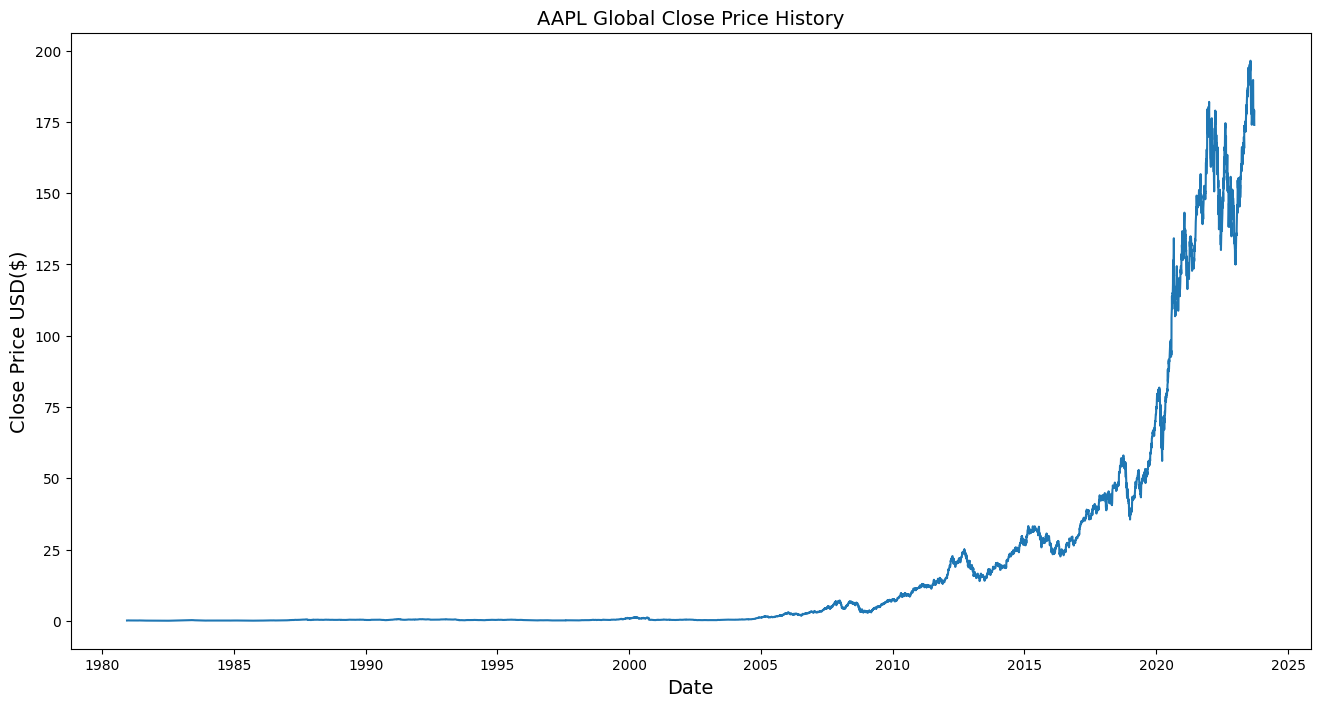

In [51]:
df = yf.download(stock)
plt.figure(figsize=(16,8))
plt.title(stock+' Global Close Price History', fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.xlabel('Date',fontsize = 14)

plt.plot(df['Close'])
plt.show()

In [52]:
## Get the stock quote

start_date = datetime.datetime(2012, 1, 1)
# end_date = datetime.datetime(2019, 12, 17)

df = yf.download(stock, start=start_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466091,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533086,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672230,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804706,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784391,394024400
...,...,...,...,...,...,...
2023-09-15,176.479996,176.500000,173.820007,175.009995,175.009995,109205100
2023-09-18,176.479996,179.380005,176.169998,177.970001,177.970001,67257600
2023-09-19,177.520004,179.630005,177.130005,179.070007,179.070007,51826900


## Selected range of Close Price History
___

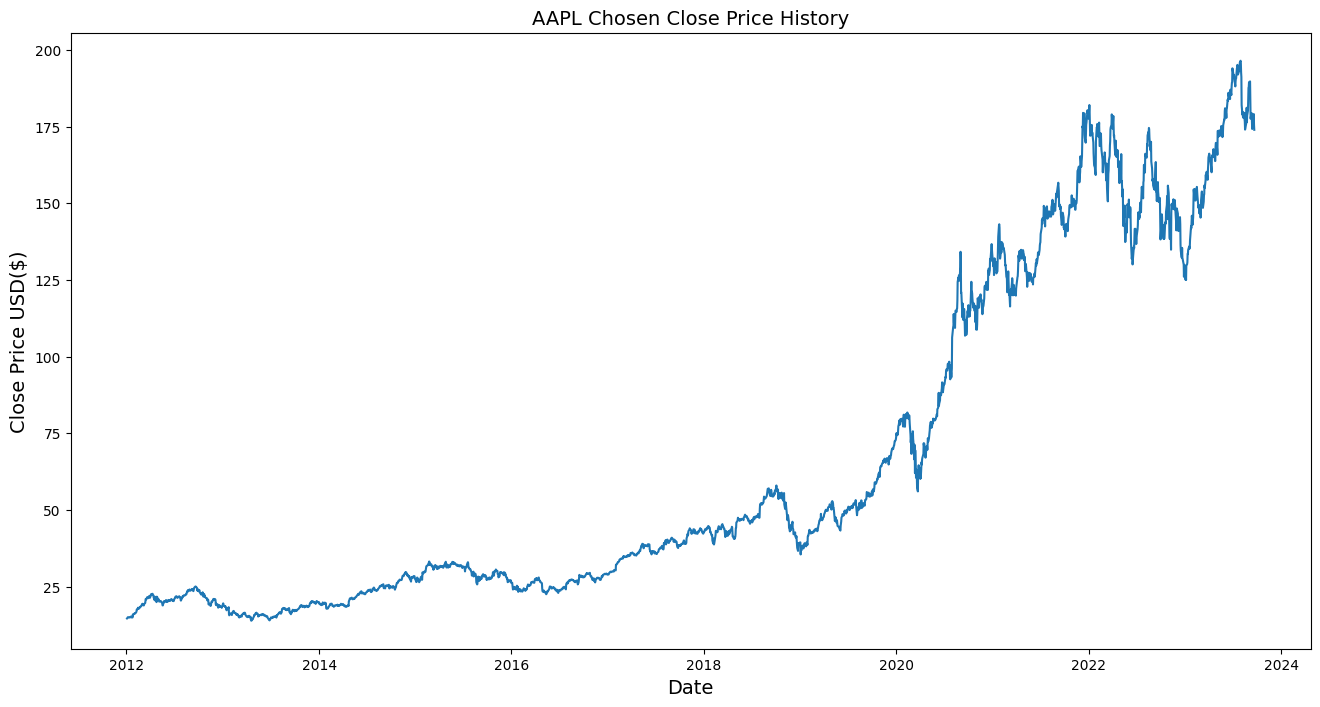

In [53]:
plt.figure(figsize=(16,8))
plt.title(stock+' Chosen Close Price History', fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.xlabel('Date',fontsize = 14)

plt.plot(df['Close'])
plt.show()

## Data Processing
---

In [54]:
data = df[['Close']]
dataset = data.values  

## Get the length of training data 
training_data_len = math.ceil(len(dataset)*0.8)   ## Ratio of Train and Test set is 8:2
training_data_len

2360

In [55]:
## Scale the data by MinMax Method

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(dataset)

In [56]:
## Hyperparameters for the training approach 

window_interval = 40  ## No. of historical records(days) for the closing price of a day
delay = 8  ## i.e. the No. of future days that we can do prediction

In [57]:
## Group the training_data of the designed value (i.e. window_interval)

train_data = scaled_data[0:training_data_len]  

x_train = []
y_train = []

for i in range(window_interval+delay, len(train_data)):
    x_train.append(train_data[i-window_interval-delay:i-delay,0])
    y_train.append(train_data[i,0])


In [58]:
## Convert the data type of x_train and y_train into Array

x_train, y_train = np.array(x_train), np.array(y_train)

In [59]:
## Reshape the data for LSTM model

i,j = x_train.shape
x_train_reshaped = np.reshape(x_train,(i,j,1))
x_train_reshaped.shape


(2312, 40, 1)

## Modeling
---

In [60]:
## Hyperparameters for the Model

num_cells_layer1 = 10
num_cells_layer2 = None
num_batch_size = 1
num_epochs = 1

In [61]:
## Build the LSTM Model

model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape= (j,1)))
model.add(LSTM(num_cells_layer1 , return_sequences=False, input_shape=(j,1)))

model.add(Dense(25))
model.add(Dense(1))

In [62]:
## Comple the model

model.compile(optimizer='adam', loss = 'mean_squared_error')

In [63]:
## Train the model

model.fit(x_train, y_train, batch_size = 1, epochs=num_epochs)

2312/2312 [==============================] - 18s 7ms/step - loss: 0.0013


In [64]:
## Group the training_data of the designed value (i.e. window_interval)

test_data = scaled_data[training_data_len-window_interval:]

x_test = []
y_test = dataset[training_data_len:,]

for i in range (window_interval,len(test_data)):
    x_test.append(test_data[i-window_interval:i,0])


In [65]:
x_test = np.array(x_test)
i,j = x_test.shape
x_test = np.reshape(x_test,(i,j,1))   
x_test

array([[[0.58159476],
        [0.58433445],
        [0.58773168],
        ...,
        [0.61545731],
        [0.60767661],
        [0.60679993]],

       [[0.58433445],
        [0.58773168],
        [0.58871797],
        ...,
        [0.60767661],
        [0.60679993],
        [0.62115587]],

       [[0.58773168],
        [0.58871797],
        [0.58055371],
        ...,
        [0.60679993],
        [0.62115587],
        [0.61085466]],

       ...,

       [[0.97972632],
        [0.98449335],
        [0.98931523],
        ...,
        [0.88652215],
        [0.88252214],
        [0.89874113]],

       [[0.98449335],
        [0.98931523],
        [0.98230164],
        ...,
        [0.88252214],
        [0.89874113],
        [0.90476848]],

       [[0.98931523],
        [0.98230164],
        [0.99660281],
        ...,
        [0.89874113],
        [0.90476848],
        [0.8851523 ]]])

In [66]:
## Do the prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # transform the value back by MinMaxScaler
len_predictions = len(predictions)

19/19 [==============================] - 1s 3ms/step


In [80]:
len_predictions = len(predictions)

## Plot the Data
---

/var/folders/0c/4yyxy27966j8h86h_vwsy3680000gn/T/ipykernel_46292/2834351389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


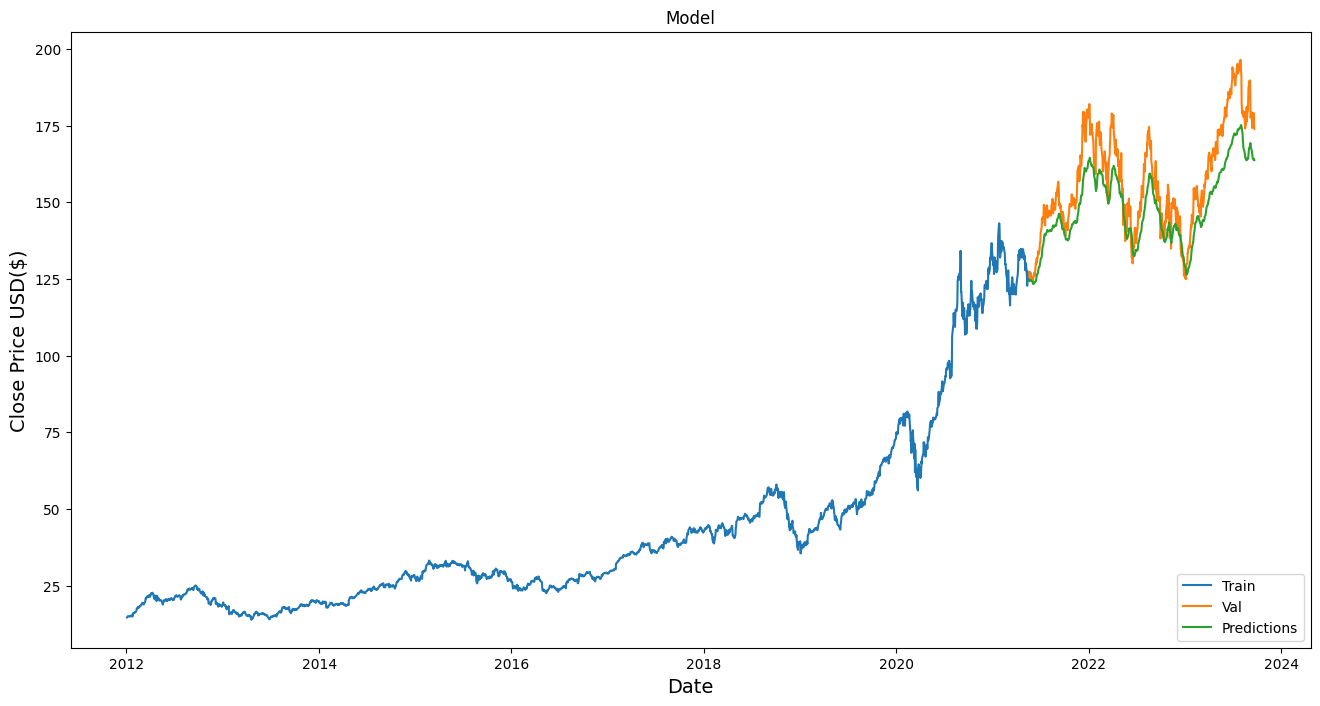

In [67]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()




## RMSE
---
Measure how the model fit the test set data. <br>
We pursue the model that best fits the test set data.

In [68]:
rmse = np.sqrt(np.mean((y_test - predictions)**2))
rmse

10.553688067151882

## Save the Prediction and Actual Closing Price
---

In [69]:
valid

,Close,Predictions
Date,,
2021-05-20,127.309998,124.358444
2021-05-21,125.430000,124.551208
2021-05-24,127.099998,124.365280
2021-05-25,126.900002,124.513565
2021-05-26,126.849998,124.587479
...,...,...
2023-09-15,175.009995,164.344147
2023-09-18,177.970001,163.846619
2023-09-19,179.070007,163.933411


In [70]:
new_row = {
    valid.columns[0]: '{0}days_{1}Cells_{2}Epoches_{3}daysdelay.csv'.format(window_interval, num_cells_layer1, num_epochs, delay),
    valid.columns[1]: "0"
}

# 使用 concat 方法将新行添加到 DataFrame
valid = pd.concat([valid, pd.DataFrame(new_row, index=[0])], ignore_index=False)

valid



,Close,Predictions
2021-05-20 00:00:00,127.309998,124.358444
2021-05-21 00:00:00,125.43,124.551208
2021-05-24 00:00:00,127.099998,124.36528
2021-05-25 00:00:00,126.900002,124.513565
2021-05-26 00:00:00,126.849998,124.587479
...,...,...
2023-09-18 00:00:00,177.970001,163.846619
2023-09-19 00:00:00,179.070007,163.933411
2023-09-20 00:00:00,175.490005,164.151184
2023-09-21 00:00:00,173.929993,163.747238


In [71]:
valid.to_csv("{0}days_{1}Cells_{2}Epoches_by{3}days_window.csv".format(delay, num_cells_layer1, num_epochs, window_interval), index=True)


## Save the model
---

In [72]:
model.save(stock+'_model')

INFO:tensorflow:Assets written to: AAPL_model/assets


INFO:tensorflow:Assets written to: AAPL_model/assets


In [78]:
## Store the info of hyperparameters of the model

model_info_text = """
## Model Info 
Stock:                     {}
num of days of prediction: {}
LSTM Cells for layer1:     {}
Epoches:                   {}
batch_size:                {}
window for prediction:     {}
---------------------------------------
## Model Result
Test set length:           {}
RMSE:                      {}""".format(stock, delay, num_cells_layer1, num_epochs, num_batch_size, window_interval, len_predictions, rmse)


In [79]:
file_name = "model_info.txt"

file_path = os.path.join(stock+'_model', file_name)


with open(file_path, 'w') as file:
    file.write(model_info_text)
